In [31]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from scipy.spatial.distance import pdist, squareform

from gnn_train_cmdline_saving import ResidualGatedGCNModel, DotDict, classify_edges

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [33]:
def prepare_inference_batch(X_Y, config):
    """
    Prepare a batch for inference based on input coordinates X_Y.
    
    Args:
        X_Y (np.ndarray): Numpy array of shape (num_nodes, 2)
        config (DotDict): Configuration dictionary
    
    Returns:
        DotDict: Prepared batch data
    """
    num_nodes = config.num_nodes
    if X_Y.shape != (num_nodes, 2):
        raise ValueError(f"X_Y must have shape ({num_nodes}, 2), but got {X_Y.shape}")
    
    batch_size = 1  # Single instance for inference
    nodes_coord = X_Y.reshape(1, num_nodes, 2).astype(np.float32)  # Shape: (1, V, 2)
    batch_x_mid = np.mean(X_Y, axis = 0)[0]
    batch_y_mid = np.mean(X_Y, axis = 0)[1]
    
    # Assign quadrants
    quadrants = np.ones(num_nodes, dtype=int)
    quadrants[X_Y[:, 0] < batch_x_mid] = 2
    quadrants[X_Y[:, 1] < batch_y_mid] = 4
    quadrants[(X_Y[:, 0] < batch_x_mid) & (X_Y[:, 1] < batch_y_mid)] = 3
    
    # Compute distance matrix
    W_val = squareform(pdist(X_Y, metric='euclidean'))
    batch_edges_values = W_val.reshape(1, num_nodes, num_nodes).astype(np.float32)  # Shape: (1, V, V)
    
    # Compute adjacency matrix
    if config.num_neighbors == -1:
        W = np.ones((num_nodes, num_nodes), dtype=np.float32)
    else:
        W = np.zeros((num_nodes, num_nodes), dtype=np.float32)
        knns = np.argpartition(W_val, config.num_neighbors, axis=1)[:, :config.num_neighbors]
        W[np.arange(num_nodes)[:, None], knns] = 1
    np.fill_diagonal(W, 2)  # Self-connections
    batch_edges = W.reshape(1, num_nodes, num_nodes).astype(np.float32)  # Shape: (1, V, V)
    
    # Since it's inference, set edges_target as zeros
    batch_edges_target = np.zeros((1, num_nodes, num_nodes), dtype=np.float32)
    
    # nodes and nodes_target (not used in inference but required by the model)
    batch_nodes = np.ones((1, num_nodes), dtype=np.float32)  # All ones for TSP
    batch_nodes_target = np.zeros((1, num_nodes), dtype=np.float32)
    
    # Dummy tour_nodes and tour_len (not used in inference)
    batch_tour_nodes = np.zeros((1, num_nodes), dtype=np.int64)
    batch_tour_len = np.zeros(1, dtype=np.float32)
    
    return DotDict(
        edges=batch_edges,               # (1, V, V)
        edges_values=batch_edges_values, # (1, V, V)
        edges_target=batch_edges_target, # (1, V, V)
        nodes=batch_nodes,               # (1, V)
        nodes_target=batch_nodes_target, # (1, V)
        nodes_coord=nodes_coord,         # (1, V, 2)
        tour_nodes=batch_tour_nodes,     # (1, V)
        tour_len=batch_tour_len,         # (1,)
        x_mid=batch_x_mid,               # (1,)
        y_mid=batch_y_mid                # (1,)
    )

In [34]:
def plot_selected_edges(X_Y, selected_edges, x_mid, y_mid, title="Inferred TSP Crossover Edges"):
    """Plot the nodes and the selected edges along with quadrant midlines."""
    num_nodes = X_Y.shape[0]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X_Y[:, 0], X_Y[:, 1], color='blue', s=50, zorder=5)
    
    # Plot selected edges
    lines = [ [X_Y[i], X_Y[j]] for (i, j) in selected_edges ]
    if lines:
        lc = LineCollection(lines, colors='green', linewidths=2, alpha=0.8)
        ax.add_collection(lc)
    
    # Plot midlines
    ax.axvline(x=x_mid, color='black', linestyle='--', linewidth=1, label='X Midline')
    ax.axhline(y=y_mid, color='black', linestyle='--', linewidth=1, label='Y Midline')
    
    # Optional: Add legend for midlines
    ax.legend()
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("X Coordinate", fontsize=14)
    ax.set_ylabel("Y Coordinate", fontsize=14)
    ax.grid(True)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

[0.5122145  0.54096666]
Model loaded from models/model_final.pth
Selected edges: [(4, 14), (4, 25), (7, 8), (10, 21), (10, 34), (11, 37), (11, 43), (13, 32), (13, 34), (16, 36), (34, 43), (37, 41)]


/tmp/ipykernel_44117/3145001858.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


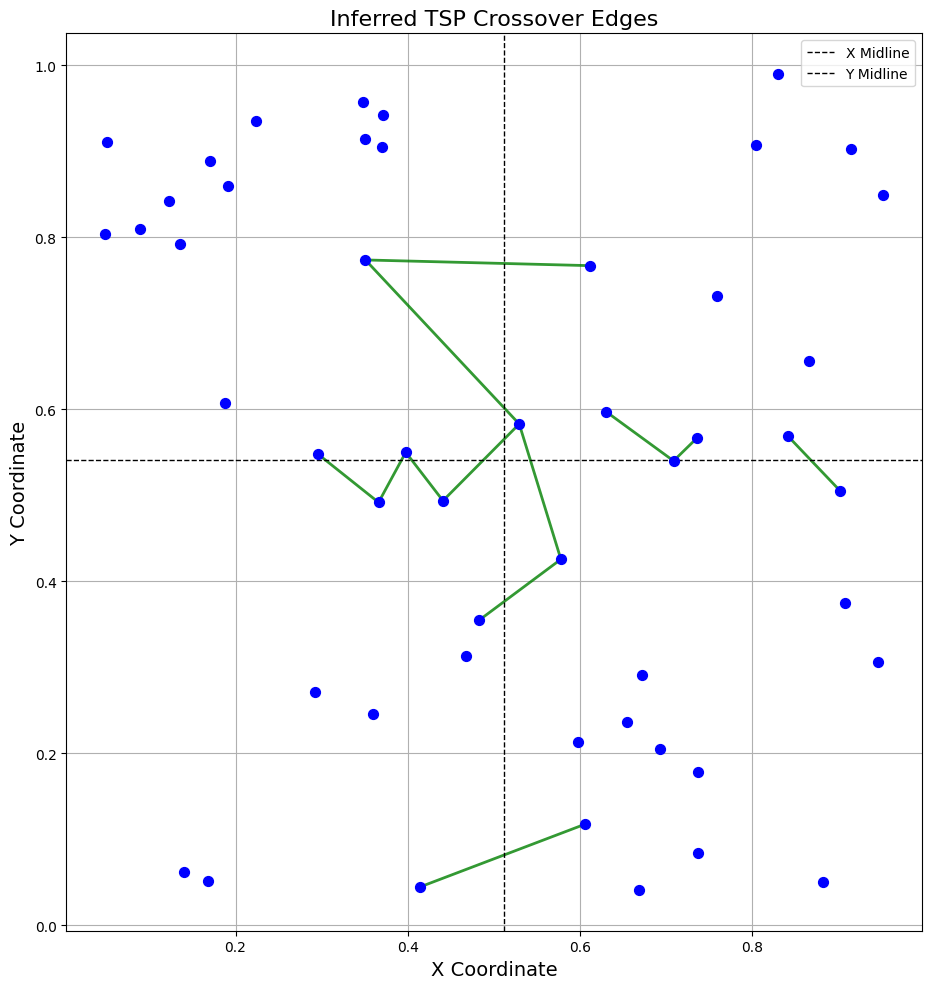

In [35]:
X_Y = np.random.rand(50, 2)
print(np.mean(X_Y, axis=0))
    
# Verify that X_Y has the correct shape
if X_Y.shape != (50, 2):
    raise ValueError(f"X_Y must have shape (50, 2), but got {X_Y.shape}")

# Define configurations as per training
config = DotDict(
    num_nodes=50,
    num_neighbors=20,
    node_dim=2,
    voc_edges_in=3,
    voc_edges_out=2,
    hidden_dim=300,
    num_layers=30,
    mlp_layers=3,
    aggregation='mean',
    batch_size=1,  # For inference, use batch_size=1
    learning_rate=0.001,  # Not needed for inference
    decay_rate=1.01,       # Not needed
    max_epochs=1500,       # Not needed
    batches_per_epoch=500, # Not needed
    accumulation_steps=1,  # Not needed
    val_every=5,           # Not needed
    test_every=25          # Not needed
)

# Prepare the batch for inference
batch = prepare_inference_batch(X_Y, config)

# Convert batch data to tensors
x_edges = torch.tensor(batch.edges, dtype=torch.long, device=device)               # (1, V, V)
x_edges_values = torch.tensor(batch.edges_values, dtype=torch.float, device=device) # (1, V, V)
x_nodes_coord = torch.tensor(batch.nodes_coord, dtype=torch.float, device=device)   # (1, V, 2)
# y_edges is not used during inference
# y_edges = torch.tensor(batch.edges_target, dtype=torch.long, device=device)       # (1, V, V)

# Initialize the model
model = ResidualGatedGCNModel(config).to(device)

# Load the saved model state_dict
model_path = os.path.join('models', 'model_final.pth')
if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=device)
    if isinstance(model, nn.DataParallel):
        model.module.load_state_dict(state_dict)
    else:
        model.load_state_dict(state_dict)
    print(f"Model loaded from {model_path}")
else:
    print(f"Model file not found at {model_path}")
    sys.exit(1)

model.eval()

# Forward pass to get edge predictions
with torch.no_grad():
    y_pred_edges = model(x_edges, x_edges_values, x_nodes_coord)  # (1, V, V, O)

# Get edge probabilities for the positive class (assuming index 1 is positive)
y_pred_probs = F.softmax(y_pred_edges, dim=3)[:, :, :, 1]  # (1, V, V)

# Classify edges based on probability threshold and maximum edges per node
y_classified = classify_edges(y_pred_probs, threshold=0.95, max_edges=2)  # (1, V, V)

# Extract selected edges from the classified tensor
selected_edges = []
V = y_classified.shape[1]
y_classified_np = y_classified.squeeze(0).cpu().numpy()  # (V, V)

for i in range(V):
    for j in range(i+1, V):
        if y_classified_np[i, j] == 1:
            selected_edges.append((i, j))

print(f"Selected edges: {selected_edges}")

if len(selected_edges) > 0:
        x_mid = batch.x_mid
        y_mid = batch.y_mid
        plot_selected_edges(X_Y, selected_edges, x_mid, y_mid, title="Inferred TSP Crossover Edges")
else:
    print("No edges were classified as crossover edges based on the threshold.")

# Optionally, save the selected edges to a file
# Example: Save as a list of tuples in a text file
# with open('selected_edges.txt', 'w') as f:
#     for edge in selected_edges:
#         f.write(f"{edge[0]} {edge[1]}\n")

# Alternatively, save as a JSON file
# import json
# with open('selected_edges.json', 'w') as f:
#     json.dump(selected_edges, f)